# Main
- This file generates the core dataset of this project by cleaning and joining household data from several years
- The unit of observation is at the household level and includes
    1. Demographic variables: age, gender, education, location, household size
    2. Income sources
    3. Consumption expenditures


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys; 
sys.path.append('../src')
sys.path.append('../dicts')
import json_utils

import utils
import os; home = os.path.expanduser('~')

from simpledbf import Dbf5

PyTables is not installed. No support for HDF output.


In [2]:
raw  = home + '/Dropbox/data/mexico_enigh/raw/'
interim = home + '/Dropbox/data/mexico_enigh/interim2/'
dicts = home + '/github/household-consumption/dicts/'

### cpi
- used to normalize price level across time

In [3]:
cpi = pd.read_csv('../data/cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])

In [4]:
cpi

,Y,cpi
73,1950,0.006298
74,1951,0.007090
75,1952,0.008101
76,1953,0.007978
77,1954,0.008365
...,...,...
141,2018,136.576649
142,2019,141.542523
143,2020,146.350488
144,2021,154.676672


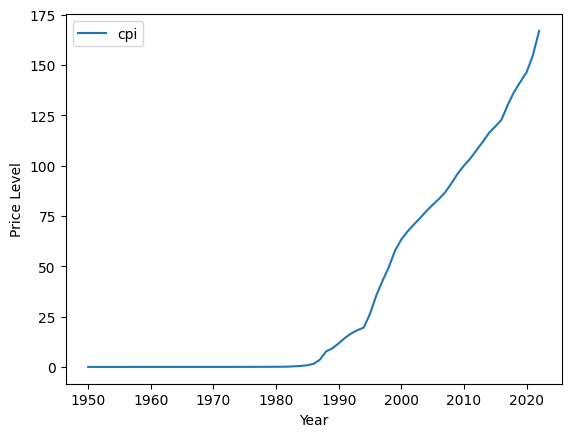

In [5]:
cpi.plot(x='Y', y='cpi')
plt.ylabel('Price Level')
plt.xlabel('Year');

In [6]:
os.chdir(dicts)
rename_main = json_utils.load_json('rename_main.json')
rename_population = json_utils.load_json('rename_population.json')
rename_income = json_utils.load_json('rename_income.json')
rename_location = json_utils.load_json('states.json')

hhm_ids = json_utils.load_json('hhm_ids.json')
education = json_utils.load_json('education.json')

print(rename_main)
print(rename_population)

{'folio': 'hhid', 'folioviv': 'hhid', 'ubica_geo': 'location', 'factor': 'weight', 'hog': 'weight', 'estrato': 'location_size', 'gastot': 'consumption_total', 'gascor': 'consumption_current', 'alimentos': 'consumption_food', 'vestido': 'consumption_clothing', 'vestido_c': 'consumption_clothing_c', 'salud': 'consumption_health', 'limpieza': 'consumption_house', 'transporte': 'consumption_transportation', 'educacion': 'consumption_education', 'personal': 'consumption_personal', 'ingtot': 'income_total', 'ingcor': 'income_current', 'trabajo': 'income_salary', 'negocio': 'income_business', 'rentas': 'income_rental', 'transfer': 'income_transfers', 'otros': 'income_other', 'pertot': 'financial_income', 'eromon': 'financial_expenditures', 'tam_hog': 'hh_size'}
{'folio': 'hhid', 'folioviv': 'hhid', 'paren': 'relationship_to_hhm', 'parentesco': 'relationship_to_hhm', 'sexo': 'sex', 'edad': 'age', 'tipo_esc': 'type_of_education', 'n_instr141': 'education', 'n_instr161': 'education', 'ed_formal'

In [7]:
# values that identify household head; change with year
hhm_ids

{'1992': [1, 2],
 '1994': [1, 2],
 '1996': [1, 2],
 '1998': [1, 2],
 '2000': [1, 2],
 '2002': [10, 11, 12],
 '2004': [100],
 '2006': [100],
 '2008': [101]}

In [8]:
# values that identify education; change with year
education

{'1992': {'0': 'Low',
  '1': 'Low',
  '2': 'Low',
  '3': 'Medium',
  '4': 'Medium',
  '5': 'Medium',
  '6': 'Medium',
  '7': 'High',
  '8': 'High',
  '9': 'High'},
 '1994': {'0': 'Low',
  '1': 'Low',
  '2': 'Low',
  '3': 'Medium',
  '4': 'Medium',
  '5': 'Medium',
  '6': 'Medium',
  '7': 'High',
  '8': 'High',
  '9': 'High'},
 '1996': {'0': 'Low',
  '1': 'Low',
  '2': 'Low',
  '3': 'Low',
  '4': 'Low',
  '5': 'Low',
  '6': 'Low',
  '7': 'Low',
  '8': 'Medium',
  '9': 'Medium',
  '10': 'Medium',
  '11': 'Medium',
  '12': 'Medium',
  '13': 'High',
  '14': 'High',
  '15': 'High',
  '16': 'High'},
 '1998': {'0': 'Low',
  '1': 'Low',
  '2': 'Low',
  '3': 'Low',
  '4': 'Low',
  '5': 'Low',
  '6': 'Low',
  '7': 'Low',
  '8': 'Low',
  '9': 'Medium',
  '10': 'Medium',
  '11': 'Medium',
  '12': 'Medium',
  '13': 'Medium',
  '14': 'High',
  '15': 'High',
  '16': 'High'},
 '2000': {'0': 'Low',
  '1': 'Low',
  '2': 'Low',
  '3': 'Low',
  '4': 'Low',
  '5': 'Low',
  '6': 'Low',
  '7': 'Low',
  '8': 

## Initial EDA: 1994 only

In [9]:
year = '1994'
os.chdir(raw + year)
main = Dbf5('main.dbf').to_dataframe()
population = Dbf5('population.dbf').to_dataframe()

main.columns = [x.lower() for x in main.columns]
population.columns = [x.lower() for x in population.columns]

In [10]:
main = main.rename(columns = rename_main)
population = population.rename(columns = rename_population)

keep_main = list(set(rename_main.values()) & set (main.columns))
keep_population = list(set(rename_population.values()) & set (population.columns))

main = main[keep_main]
population = population[keep_population]

In [11]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12815 entries, 0 to 12814
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   consumption_education       12815 non-null  float64
 1   income_transfers            12815 non-null  float64
 2   consumption_current         12815 non-null  float64
 3   income_salary               12815 non-null  float64
 4   hh_size                     12815 non-null  int64  
 5   location_size               12815 non-null  object 
 6   income_total                12815 non-null  float64
 7   consumption_personal        12815 non-null  float64
 8   financial_expenditures      12815 non-null  float64
 9   financial_income            12815 non-null  float64
 10  consumption_health          12815 non-null  float64
 11  consumption_food            12815 non-null  float64
 12  hhid                        12815 non-null  object 
 13  income_business             128

In [12]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60353 entries, 0 to 60352
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   education            60353 non-null  object
 1   relationship_to_hhm  60353 non-null  object
 2   type_of_education    60353 non-null  object
 3   hhid                 60353 non-null  object
 4   sex                  60353 non-null  object
 5   education_technical  60353 non-null  object
 6   age                  60353 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 3.2+ MB


In [13]:
main.isna().sum()

consumption_education         0
income_transfers              0
consumption_current           0
income_salary                 0
hh_size                       0
location_size                 0
income_total                  0
consumption_personal          0
financial_expenditures        0
financial_income              0
consumption_health            0
consumption_food              0
hhid                          0
income_business               0
weight                        0
consumption_transportation    0
income_rental                 0
location                      0
consumption_house             0
consumption_clothing          0
income_other                  0
income_current                0
consumption_total             0
dtype: int64

In [14]:
population.isna().sum()

education              0
relationship_to_hhm    0
type_of_education      0
hhid                   0
sex                    0
education_technical    0
age                    0
dtype: int64

In [15]:
# check for duplicates along primary key hhid
print('main duplicates:', main.hhid.duplicated().sum())

main duplicates: 0


Text(0.5, 1.0, 'sex')

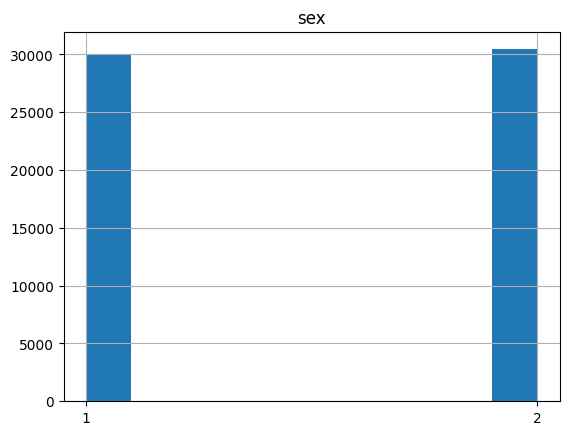

In [16]:
population['sex'].hist()
plt.title('sex')

Text(0.5, 1.0, 'education (indicator)')

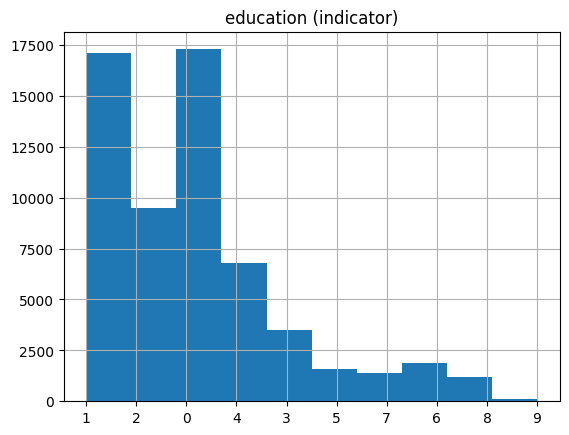

In [17]:
population['education'].hist(bins=len(population.education.unique()))
plt.title('education (indicator)')

Text(0.5, 1.0, 'Distribution of Age')

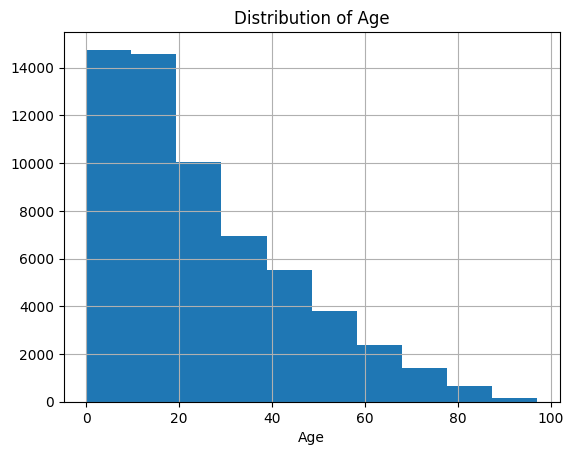

In [18]:
population['age'].hist()
plt.xlabel('Age')
plt.title('Distribution of Age')

In [19]:
years = ['1994', '1996']
dfs = []

for year in years:
    print('-------------------------------------')
    print('Making year ' + year)
    os.chdir(raw + year)
    main = Dbf5('main.dbf').to_dataframe()
    population = Dbf5('population.dbf').to_dataframe()

    print('Number of people:', len(population))
    print('Number of households:', len(main))

    main.columns = [x.lower() for x in main.columns]
    population.columns = [x.lower() for x in population.columns]
     
    # rename to english column names
    main = main.rename(columns = rename_main)
    population = population.rename(columns = rename_population)

    keep_main = list(set(rename_main.values()) & set (main.columns))
    keep_population = list(set(rename_population.values()) & set (population.columns))

    # only keep selected columns; a column is only kept if it is renamed
    main = main[keep_main]
    population = population[keep_population]

    # identify the head of household and restrict population data to household heads
    population['relationship_to_hhm'] = population['relationship_to_hhm'].astype('int')
    population['is_household_head'] = population['relationship_to_hhm'].apply(lambda x : x in hhm_ids[year])
    population = population.query('is_household_head == True')
    print('Number of household heads', len(population))

    # reformat education; can change depending on year
    population['education'] = (population['education']
                               .astype(int)
                               .apply(lambda x : education[year][str(x)])
                               .astype(str))

    # merge main variables with demographic data
    # merge on hhid - household identification number
    df = main.merge(population, on='hhid')

    # add year indicator
    df['Y'] = int(year)

    # add to list of dataframes for each year
    dfs.append(df)

-------------------------------------
Making year 1994
Number of people: 60353
Number of households: 12815
Number of household heads 12815
-------------------------------------
Making year 1996
Number of people: 64916
Number of households: 14042
Number of household heads 14042


In [20]:
# collect yearly dataframes into a single dataframe
df = pd.concat(dfs).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26857 entries, 0 to 26856
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   consumption_education       26857 non-null  float64
 1   income_transfers            26857 non-null  float64
 2   consumption_current         26857 non-null  float64
 3   income_salary               26857 non-null  float64
 4   hh_size                     26857 non-null  int64  
 5   location_size               26857 non-null  object 
 6   income_total                26857 non-null  float64
 7   consumption_personal        26857 non-null  float64
 8   financial_expenditures      26857 non-null  float64
 9   financial_income            26857 non-null  float64
 10  consumption_health          26857 non-null  float64
 11  consumption_food            26857 non-null  float64
 12  hhid                        26857 non-null  object 
 13  income_business             268

# Gender

In [21]:
# sex of household head, is biased towards male
df['sex'] = df['sex'].replace({'1' : 'Male', '2':'Female'})
df.sex.value_counts(dropna=False)

sex
Male      22899
Female     3958
Name: count, dtype: int64

# Location

In [22]:
df['location'] = df.location.str[:2].astype(int)
df['location'] = df['location'].astype(str).replace(rename_location)
df['location'].value_counts()

location
Durango                2103
Mexico City            2005
Chiapas                1744
State of Mexico        1322
Veracruz               1272
Tabasco                1218
Puebla                 1188
Guerrero               1159
Aguascalientes         1105
Jalisco                1103
Campeche               1076
Oaxaca                 1044
Nuevo Leon              748
Tlaxcala                563
Coahuila                557
Sinaloa                 554
Colima                  543
Guanajuato              535
Hidalgo                 535
Sonora                  530
Zacatecas               528
Michoacan               528
Queretaro               519
San Luis Potosi         511
Yucatan                 509
Nayarit                 496
Tamaulipas              492
Morelos                 487
Quintana Roo            480
Baja California Sur     470
Chihuahua               467
Baja California         466
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='location'>

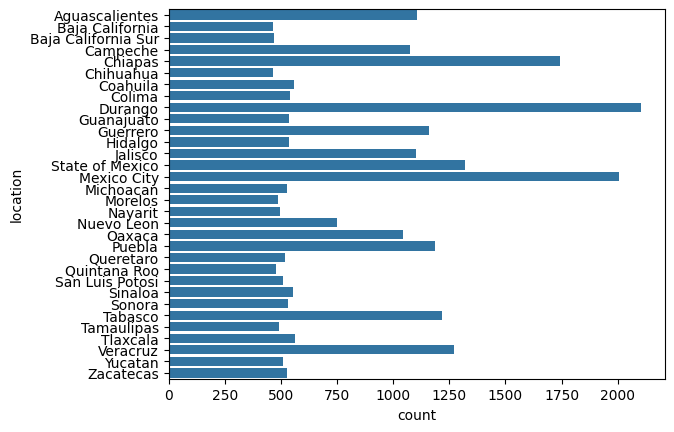

In [23]:
sns.countplot(df, y='location')

## Income and Consumption: Normalization and Outliers
- This section normalizes income and consumption by two variables
  - The size of the household, as larger households have larger expenditures and workers
  - The price level (cpi), which changes over time
- I remove households that 
  - Earn zero income
  - Have zero consumption
  - Are above the 99.9% percentile of consumption or income

In [24]:
income_sources = ['income_salary', 'income_business', 'income_transfers']
consumption_sources = ['consumption_food', 'consumption_personal', 'consumption_clothing']

df['income'] = df[income_sources].sum(axis=1)
df['consumption'] = df[consumption_sources].sum(axis=1)

In [25]:
"""Normalization
This section normalizes income and consumption measures by two factors:
1. Household size (hh_size)
2. The price level at the time, given by the cpi (cpi)
"""
df = df.merge(cpi, on='Y', how='left')
for column in df.columns:
    if 'income' in column or 'consumption' in column:
        df[column]  = df[column] / df['cpi']
        df[column] = df[column] / df['hh_size']

In [26]:
# remove households that do not consume anything in our primary measure
len_init = len(df)
df = df[df.consumption > 0]
len_finish = len(df)
print('Lost due to zero consumption:', 100*(len_init - len_finish) / len_init, '%')

# remove household that earn no income
len_init = len(df)
df = df[df.income > 0]
len_finish = len(df)
print('Lost due to zero income:', 100*(len_init - len_finish) / len_init, '%')

Lost due to zero consumption: 0.43564061510965485 %
Lost due to zero income: 0.512341062079282 %


### Distribution of income

array([[<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'consumption'}>]], dtype=object)

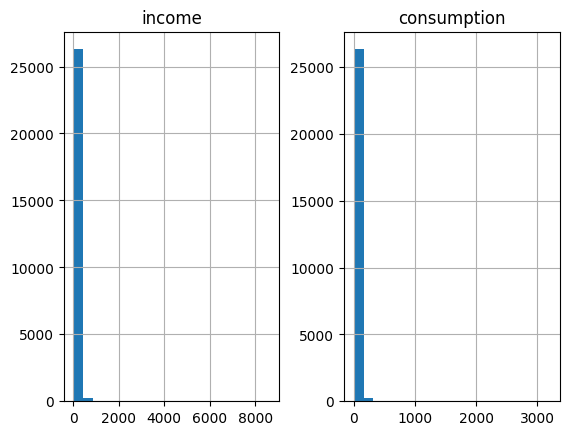

In [27]:
"""Basic histograms of income and consumption - we can see they subject so severe outliers, as is normal for income and consumption distributions
"""
df[['income', 'consumption']].hist(bins=20)

In [28]:
# remove right tail outliers for consumption and income 
q_999 = lambda x : np.quantile(x, 0.999)

len_init = len(df)
df = df[df.consumption <= df.groupby('Y', as_index=False)['consumption'].transform(q_999)]
len_final = len(df)
print(f'Lost due to consumption:{100*(len_init - len_final) / len_init :.2f} %')

len_init = len(df)
df = df[df.income <= df.groupby('Y', as_index=False)['income'].transform(q_999)]
len_final = len(df)
print(f'Lost due to income:{100*(len_init - len_final) / len_init :.2f} %')

Lost due to consumption:0.10 %
Lost due to income:0.10 %


array([[<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'consumption'}>]], dtype=object)

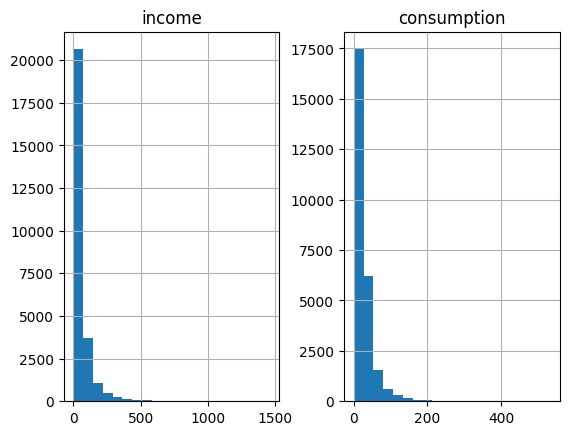

In [29]:
df[['income', 'consumption']].hist(bins=20)

In [30]:
# form log income and log consumption for modeling
df['log_income'] = np.log(df['income'])
df['log_consumption'] = np.log(df['consumption'])

array([[<Axes: title={'center': 'log_income'}>,
        <Axes: title={'center': 'log_consumption'}>]], dtype=object)

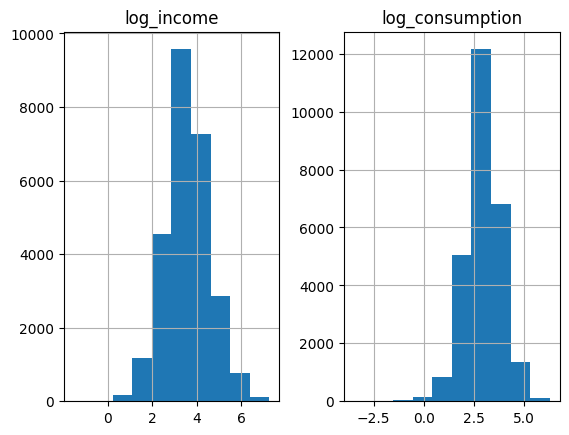

In [31]:
df[['log_income', 'log_consumption']].hist()

<Axes: xlabel='log_income', ylabel='log_consumption'>

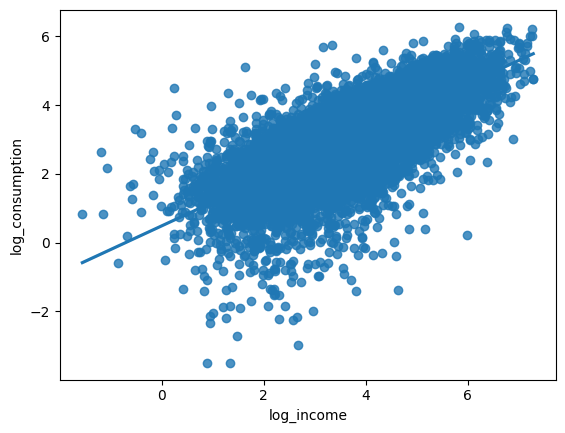

In [32]:
sns.regplot(df, x='log_income', y='log_consumption')

# Education

In [33]:
df['education'] = pd.Categorical(df['education'], categories=['Low', 'Medium', 'High'], ordered=True)
df['education'] = df['education'].cat.reorder_categories(['Low', 'Medium', 'High'])
df.education.value_counts(dropna=False)

education
Low       18095
Medium     6028
High       2426
Name: count, dtype: int64

<Axes: >

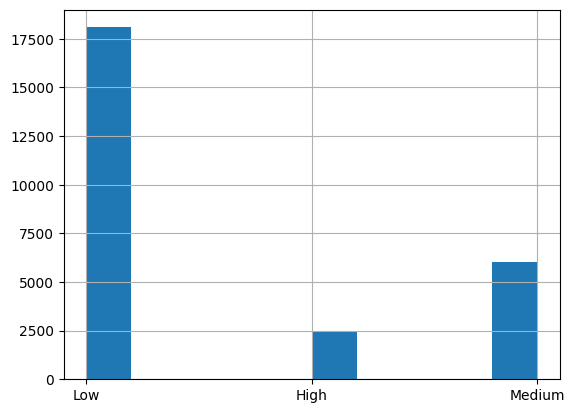

In [34]:
df.education.hist()

# Controlling for age
1. This section controls for age 
2. We want to remove 'young' households that are just starting, and old households that rely on financial income
3. Because our observations are at the level of the household head, who is typically middle age, we only lose 0.2% of observations 

In [35]:
# add square of age for later modeling
df['age_sq'] = df['age']**2

# remove household heads out of age bounds
len_init = len(df)
df = (df.query('age>=25')
      .query('age<=60'))
len_finish = len(df)
print('Lost due to age:', (len_init - len_finish) / len_init, '%')

Lost due to age: 0.23164714301856945 %


In [36]:
os.chdir(interim)
df.to_csv('main.csv', index=False)